# Twitter author prediction

## Prerequisites

### Importing necessary libraries

In [12]:
import random; random.seed(53)
import pandas as pd

# Import all we need from sklearn
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.model_selection import cross_val_score
import itertools


In [13]:
import matplotlib.pyplot as plt
import numpy as np
def plot_and_return_top_features(classifier, vectorizer, top_features=20):
    """
    Plot the top features in a binary classification model and remove possible overlap.

    Adapted from https://medium.com/@aneesha/visualising-top-features-in-linear-svm-with-scikit-learn-and-matplotlib-3454ab18a14d
    and https://stackoverflow.com/a/26980472 by @kjam
    """
    class_labels = classifier.classes_
    feature_names = vectorizer.get_feature_names_out()
    topn_class1 = sorted(zip(classifier.coef_[0], feature_names))[:top_features]
    topn_class2 = sorted(zip(classifier.coef_[0], feature_names))[-top_features:]
    top_coefficients = np.hstack([topn_class1, topn_class2])
    if set(topn_class1).union(topn_class2):
        top_coefficients = topn_class1
        for ce in topn_class2:
            if ce not in topn_class1:
                top_coefficients.append(ce)

    plt.figure(figsize=(15, 5))
    colors = ['red' if c < 0 else 'blue' for c in [tc[0] for tc in top_coefficients]]
    plt.bar(np.arange(len(top_coefficients)), [tc[0] for tc in top_coefficients], color=colors)
    plt.xticks(np.arange(len(top_coefficients)),
               [tc[1] for tc in top_coefficients], rotation=60, ha='right')
    plt.show()
    return top_coefficients

In [14]:

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues,
                          figure=0):
    """
    See full source and example:
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figure)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')



### Load the data

In [15]:
# Load data
tweet_df = pd.read_csv("C:/Users/Oliver/Documents/BCE/Tárgyak/9. félév/Többváltozós statisztika/tweets.csv")


Ez a másik adatbázis

In [16]:
# Vakhal
# Load data
tweet_df = pd.read_csv("C:/Users/Oliver/Documents/BCE/Tárgyak/9. félév/Többváltozós statisztika/tweets_1.csv")
#extract the texts and the authors where the author is either HillaryClinton or realDonaldTrump
tweet_df = tweet_df[tweet_df.is_retweet == False]
tweet_df = tweet_df[["handle", "text"]]
tweet_df.columns = ["author", "status"]


In [17]:
# Create target
y = tweet_df["author"]
# Split training and testing data
X_train, X_test, y_train, y_test = train_test_split(tweet_df["status"], y,  test_size=0.2, stratify=y, random_state=42)

## Data cleaning

### CountVectorizer

In [18]:
count_vectorizer = CountVectorizer(stop_words="english", min_df=0.05, max_df=0.9)
count_train = count_vectorizer.fit_transform(X_train)
count_test = count_vectorizer.transform(X_test)

### Tf-Idf

In [19]:
tfidf_vectorizer = TfidfVectorizer(stop_words="english", min_df=0.05, max_df=0.9)
tfidf_train = tfidf_vectorizer.fit_transform(X_train)
tfidf_test = tfidf_vectorizer.transform(X_test)

## Training the models

### Training a multinomial naive Bayes model

In [20]:
# Create and fit the model for the tf-idf data
tf_idf_nb = MultinomialNB()
tf_idf_nb.fit(tfidf_train, y_train)
tf_idf_nb_pred = tf_idf_nb.predict(tfidf_test)

print(tf_idf_nb.get_params())

# Create and fit the model for the count data
count_nb = MultinomialNB()
count_nb.fit(count_train, y_train)
count_nb_pred = count_nb.predict(count_test)

{'alpha': 1.0, 'class_prior': None, 'fit_prior': True, 'force_alpha': 'warn'}


### Training an SVM model

In [21]:
tf_idf_svc = LinearSVC(dual=False)
tf_idf_svc.fit(tfidf_train, y_train)
tf_idf_svc_pred = tf_idf_svc.predict(tfidf_test)

### Training a logistic regression model

In [22]:
tf_idf_lr = LogisticRegression()
tf_idf_lr.fit(tfidf_train, y_train)
tf_idf_lr_pred = tf_idf_lr.predict(tfidf_test)

### Training a decision tree model

In [23]:
tf_idf_dt = DecisionTreeClassifier()
tf_idf_dt.fit(tfidf_train, y_train)
tf_idf_dt_pred = tf_idf_dt.predict(tfidf_test)

### Training a random forest model

In [24]:
tf_idf_rf = RandomForestClassifier(oob_score=True)
tf_idf_rf.fit(tfidf_train, y_train)
tf_idf_rf_pred = tf_idf_rf.predict(tfidf_test)

## Accuracy scores (for the tf-idf vectorizer)

In [25]:
target_values = list(tf_idf_lr.classes_)
target_values

['HillaryClinton', 'realDonaldTrump']

### Confusion matrices

In [26]:
tf_idf_nb_cm = metrics.confusion_matrix(y_test, tf_idf_nb_pred, labels=target_values, normalize='true')
tf_idf_svc_cm = metrics.confusion_matrix(y_test, tf_idf_svc_pred, labels=target_values, normalize='true')
tf_idf_lr_cm = metrics.confusion_matrix(y_test, tf_idf_lr_pred, labels=target_values, normalize='true')
tf_idf_dt_cm = metrics.confusion_matrix(y_test, tf_idf_dt_pred, labels=target_values, normalize='true')
tf_idf_rf_cm = metrics.confusion_matrix(y_test, tf_idf_rf_pred, labels=target_values, normalize='true')

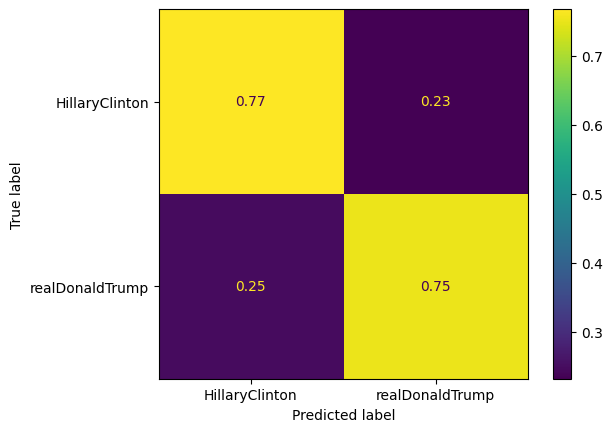

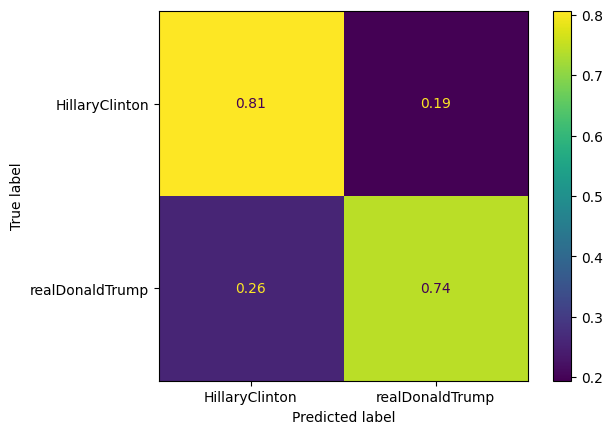

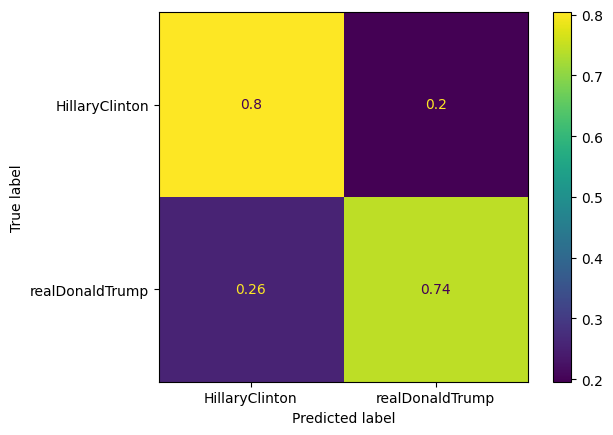

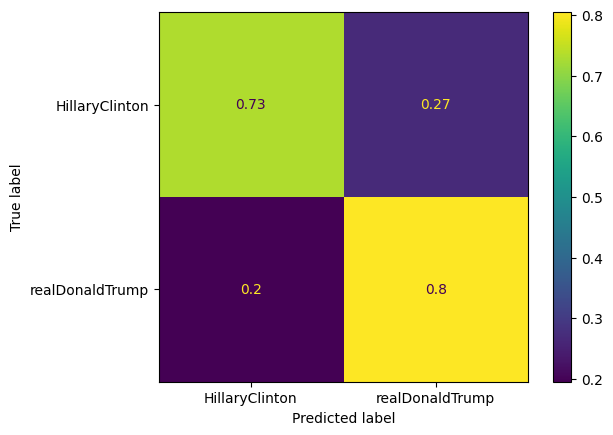

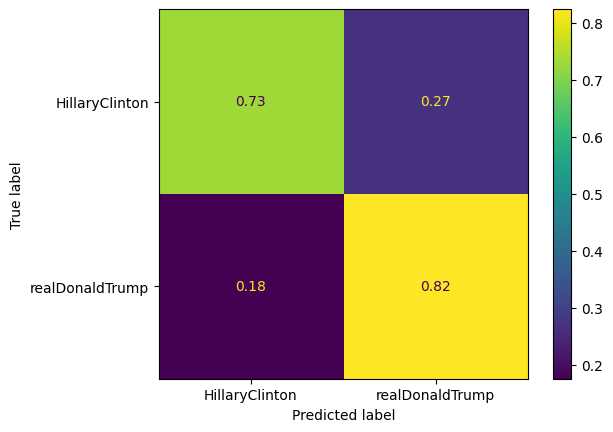

In [27]:
metrics.ConfusionMatrixDisplay(tf_idf_nb_cm, display_labels=target_values).plot()
metrics.ConfusionMatrixDisplay(tf_idf_svc_cm, display_labels=target_values).plot()
metrics.ConfusionMatrixDisplay(tf_idf_lr_cm, display_labels=target_values).plot()
metrics.ConfusionMatrixDisplay(tf_idf_dt_cm, display_labels=target_values).plot()
metrics.ConfusionMatrixDisplay(tf_idf_rf_cm, display_labels=target_values).plot()

### Accuracy scores of the models

In [28]:
print("Naive Bayes\t\t", tf_idf_nb.score(tfidf_test, y_test))
print("SVC\t\t\t", tf_idf_svc.score(tfidf_test, y_test))
print("Logistic Regression\t", tf_idf_lr.score(tfidf_test, y_test))
print("Decision Tree\t\t", tf_idf_dt.score(tfidf_test, y_test))
print("Random Forest\t\t", tf_idf_rf.score(tfidf_test, y_test))

Naive Bayes		 0.759825327510917
SVC			 0.7720524017467248
Logistic Regression	 0.77117903930131
Decision Tree		 0.77117903930131
Random Forest		 0.7816593886462883


### Cross-validation

In [29]:
print(f"Naive Bayes:\t\t{cross_val_score(tf_idf_nb, tfidf_train, y_train, cv=5).mean()}")
print(f"SVC:\t\t\t{cross_val_score(tf_idf_svc, tfidf_train, y_train, cv=5).mean()}")
print(f"Logistic Regression:\t{cross_val_score(tf_idf_lr, tfidf_train, y_train, cv=5).mean()}")
print(f"Decision Tree:\t\t{cross_val_score(tf_idf_dt, tfidf_train, y_train, cv=5).mean()}")
print(f"Random Forest:\t\t{cross_val_score(tf_idf_rf, tfidf_train, y_train, cv=5).mean()}")

Naive Bayes:		0.756175102011597
SVC:			0.7655668504068533
Logistic Regression:	0.7666597465817168
Decision Tree:		0.777808480683418
Random Forest:		0.7808676354785598


### Recall scores of the models

In [30]:
print("Naive Bayes", metrics.recall_score(y_test, tf_idf_nb_pred, labels=target_values, pos_label=target_values[0]))
print("SVC", metrics.recall_score(y_test, tf_idf_svc_pred, labels=target_values, pos_label=target_values[0]))
print("Logistic Regression", metrics.recall_score(y_test, tf_idf_lr_pred, labels=target_values, pos_label=target_values[0]))
print("Decision Tree", metrics.recall_score(y_test, tf_idf_dt_pred, labels=target_values, pos_label=target_values[0]))
print("Random Forest", metrics.recall_score(y_test, tf_idf_rf_pred, labels=target_values, pos_label=target_values[0]))

Naive Bayes 0.7680608365019012
SVC 0.8060836501901141
Logistic Regression 0.8041825095057035
Decision Tree 0.7319391634980988
Random Forest 0.7319391634980988


### Precision scores of the models

In [31]:
print("Naive Bayes", metrics.precision_score(y_test, tf_idf_nb_pred, labels=target_values, pos_label=target_values[0]))
print("SVC", metrics.precision_score(y_test, tf_idf_svc_pred, labels=target_values, pos_label=target_values[0]))
print("Logistic Regression", metrics.precision_score(y_test, tf_idf_lr_pred, labels=target_values, pos_label=target_values[0]))
print("Decision Tree", metrics.precision_score(y_test, tf_idf_dt_pred, labels=target_values, pos_label=target_values[0]))
print("Random Forest", metrics.precision_score(y_test, tf_idf_rf_pred, labels=target_values, pos_label=target_values[0]))

Naive Bayes 0.725314183123878
SVC 0.7272727272727273
Logistic Regression 0.7268041237113402
Decision Tree 0.7608695652173914
Random Forest 0.7793522267206477


### f1-scores of the models

In [32]:
print("Naive Bayes", metrics.f1_score(y_test, tf_idf_nb_pred, labels=target_values, pos_label=target_values[0]))
print("SVC", metrics.f1_score(y_test, tf_idf_svc_pred, labels=target_values, pos_label=target_values[0]))
print("Logistic Regression", metrics.f1_score(y_test, tf_idf_lr_pred, labels=target_values, pos_label=target_values[0]))
print("Decision Tree", metrics.f1_score(y_test, tf_idf_dt_pred, labels=target_values, pos_label=target_values[0]))
print("Random Forest", metrics.f1_score(y_test, tf_idf_rf_pred, labels=target_values, pos_label=target_values[0]))

Naive Bayes 0.7460757156048015
SVC 0.7646528403967539
Logistic Regression 0.7635379061371842
Decision Tree 0.7461240310077518
Random Forest 0.7549019607843137


### Classification reports

In [37]:
# classification report
report_nb = metrics.classification_report(y_test, tf_idf_nb_pred, labels=target_values, output_dict=True)
report_svm = metrics.classification_report(y_test, tf_idf_svc_pred, labels=target_values, output_dict=True)
report_lr = metrics.classification_report(y_test, tf_idf_lr_pred, labels=target_values, output_dict=True)
report_dt = metrics.classification_report(y_test, tf_idf_dt_pred, labels=target_values, output_dict=True)
report_rf = metrics.classification_report(y_test, tf_idf_rf_pred, labels=target_values, output_dict=True)




df_nb = pd.DataFrame.from_dict(report_nb).transpose()
df_svm = pd.DataFrame.from_dict(report_svm).transpose()
df_lr = pd.DataFrame.from_dict(report_lr).transpose()
df_dt = pd.DataFrame.from_dict(report_dt).transpose()
df_rf = pd.DataFrame.from_dict(report_rf).transpose()

print("Naive Bayes")
print(df_nb)
print()
print("SVM")
print(df_svm)
print()
print("Logistic Regression")
print(df_lr)
print()
print("Decision Tree")
print(df_dt)
print()
print("Random Forest")
print(df_rf)

Naive Bayes
                 precision    recall  f1-score      support
HillaryClinton    0.725314  0.768061  0.746076   526.000000
realDonaldTrump   0.792517  0.752827  0.772162   619.000000
accuracy          0.759825  0.759825  0.759825     0.759825
macro avg         0.758916  0.760444  0.759119  1145.000000
weighted avg      0.761645  0.759825  0.760178  1145.000000

SVM
                 precision    recall  f1-score      support
HillaryClinton    0.727273  0.806084  0.764653   526.000000
realDonaldTrump   0.818505  0.743134  0.779001   619.000000
accuracy          0.772052  0.772052  0.772052     0.772052
macro avg         0.772889  0.774609  0.771827  1145.000000
weighted avg      0.776594  0.772052  0.772410  1145.000000

Logistic Regression
                 precision    recall  f1-score      support
HillaryClinton    0.726804  0.804183  0.763538   526.000000
realDonaldTrump   0.817052  0.743134  0.778342   619.000000
accuracy          0.771179  0.771179  0.771179     0.771179
ma

### Roc-auc scores of the models

In [23]:
print("Naive Bayes", metrics.roc_auc_score(y_test, tf_idf_nb.predict_proba(tfidf_test)[:,1]))
print("SVC does not support predict_proba")
print("Logistic Regression", metrics.roc_auc_score(y_test, tf_idf_lr.predict_proba(tfidf_test)[:,1]))
print("Decision Tree", metrics.roc_auc_score(y_test, tf_idf_dt.predict_proba(tfidf_test)[:,1]))
print("Random Forest", metrics.roc_auc_score(y_test, tf_idf_rf.predict_proba(tfidf_test)[:,1]))

Naive Bayes 0.8165046038931921
SVC does not support predict_proba
Logistic Regression 0.8401137613100979
Decision Tree 0.8352764485832049
Random Forest 0.8531100081696836
